## Etapa 1: Instalação das bibliotecas

In [0]:
!echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   7040      0 --:--:-- --:--:-- --:--:--  7023
OK


In [0]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (1.14.0).
0 upgraded, 0 newly installed, 0 to remove and 107 not upgraded.


In [0]:
!pip install tensorflow-gpu==1.13.1

In [0]:
!pip install requests

## Etapa 2: Importação das bibliotecas

In [0]:
import os
import json
import random
import requests
import subprocess
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

%matplotlib inline
tf.__version__

'1.13.1'

## Etapa 3: Pré-processamento

### Carregando a base de dados

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [0]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Normalização das imagens

In [0]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [0]:
X_train.shape

(50000, 32, 32, 3)

In [0]:
X_test.shape

(10000, 32, 32, 3)

In [0]:
y_test

array([[3],
       [8],
       [8],
       ...,
       [5],
       [1],
       [7]])

## Etapa 4: Definição do modelo

NOTA: Estamos usando o mesmo modelo da seção sobre Redes Neurais Convolucionais

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))

### Compilando o modelo

In [0]:
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

### Treinando o modelo

In [0]:
model.fit(X_train, 
          y_train, 
          batch_size=128, 
          epochs=10)

Epoch 1/10
50000/50000 [==============================] - 12s 249us/sample - loss: 1.4954 - sparse_categorical_accuracy: 0.4616
Epoch 2/10
50000/50000 [==============================] - 11s 222us/sample - loss: 1.0436 - sparse_categorical_accuracy: 0.6316
Epoch 3/10
50000/50000 [==============================] - 11s 217us/sample - loss: 0.8507 - sparse_categorical_accuracy: 0.7019
Epoch 4/10
50000/50000 [==============================] - 11s 216us/sample - loss: 0.7289 - sparse_categorical_accuracy: 0.7467
Epoch 5/10
50000/50000 [==============================] - 11s 217us/sample - loss: 0.6350 - sparse_categorical_accuracy: 0.7802
Epoch 6/10
50000/50000 [==============================] - 11s 218us/sample - loss: 0.5519 - sparse_categorical_accuracy: 0.8070
Epoch 7/10
50000/50000 [==============================] - 11s 214us/sample - loss: 0.4698 - sparse_categorical_accuracy: 0.8347
Epoch 8/10
50000/50000 [==============================] - 11s 216us/sample - loss: 0.3985 - sparse_categ

### Avaliação do modelo

In [0]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

10000/10000 [==============================] - 2s 170us/sample - loss: 0.9174 - sparse_categorical_accuracy: 0.7503


In [0]:
print("Test accuracy is {}".format(test_accuracy))

Test accuracy is 0.7502999901771545


## Etapa 5: Salvando o modelo para produção

### Criando o diretório para o modelo

In [0]:
model_dir = "model/"
version = 1

In [0]:
export_path = os.path.join(model_dir, str(version))
export_path

'model/1'

In [0]:
if os.path.isdir(export_path):
  !rm -r {export_path}

### Salvando o modelo para o TensorFlow Serving

In [0]:
model.input

<tf.Tensor 'conv2d_4_input:0' shape=(?, 32, 32, 3) dtype=float32>

In [0]:
model.outputs

[<tf.Tensor 'dense_3/Softmax:0' shape=(?, 10) dtype=float32>]

In [0]:
o = {t.name: t for t in model.outputs}

In [0]:
o

{'dense_3/Softmax:0': <tf.Tensor 'dense_3/Softmax:0' shape=(?, 10) dtype=float32>}

In [0]:
tf.saved_model.simple_save(tf.keras.backend.get_session(), export_dir = export_path,
                           inputs = {"input_image": model.input},
                           outputs = {t.name: t for t in model.outputs})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: model/1/saved_model.pb


## Etapa 6: Configuração do ambiente de produção

### Exportando o MODEL_DIR para as variáveis de ambiente

In [0]:
os.environ["model_dir"] = os.path.abspath(model_dir)

### Executando a API TensorFlow Serving REST

In [0]:
%%bash --bg
nohup tensorflow_model_server --rest_api_port=8501 --model_name=cifar10 --model_base_path="${model_dir}" >server.log 2>&1

Starting job # 0 in a separate thread.


In [0]:
!tail server.log

2019-09-18 21:17:28.054345: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] Reading SavedModel from: /content/model/1
2019-09-18 21:17:28.058065: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:54] Reading meta graph with tags { serve }
2019-09-18 21:17:28.061393: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2019-09-18 21:17:28.082780: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:202] Restoring SavedModel bundle.
2019-09-18 21:17:28.130135: I external/org_tensorflow/tensorflow/cc/saved_model/loader.cc:311] SavedModel load for tags { serve }; Status: success. Took 75781 microseconds.
2019-09-18 21:17:28.130197: I tensorflow_serving/servables/tensorflow/saved_model_warmup.cc:103] No warmup data file found at /content/model/1/assets.extra/tf_serving_warmup_requests
2019-09-18 21:17:28.130299: I tensorflow_serving/core

## Etapa 7: Criando a primeira requisição POST

In [0]:
random_image = np.random.randint(0, len(X_test))

In [0]:
random_image

3337

### Criando o objeto JSON

In [0]:
data = json.dumps({"signature_name": "serving_default", "instances": [X_test[random_image].tolist()]})

In [0]:
data

'{"signature_name": "serving_default", "instances": [[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [0.9921568627450981, 1.0, 1.0], [0.9215686274509803, 0.9372549019607843, 0.9333333333333333], [0.9333333333333333, 0.9450980392156862, 0.9450980392156862], [0.984313725490196, 1.0, 0.996078431372549], [0.9333333333333333, 0.9490196078431372, 0.9450980392156862], [0.8941176470588236, 0.9215686274509803, 0.8901960784313725], [0.8196078431372549, 0.8666666666666667, 0.788235294117647], [0.7764705882352941, 0.8352941176470589, 0.7333333333333333], [0.7411764705882353, 0.803921568627451, 0.6941176470588235], [0.6823529411764706, 0.7568627450980392, 0.6588235294117647], [0.7294117647058823, 0.8117647058823529, 0.7333333333333333], [0.7843137254901961, 0.8627450980392157, 0.807843137254902], [0.8117647058823529, 0.8862745098039215, 0.8392

### Enviando a primeira requisição POST para o modelo

In [0]:
headers = {"content-type": "application/json"}

In [0]:
json_response = requests.post(url="http://localhost:8501/v1/models/cifar10:predict", data = data, headers = headers)

In [0]:
json_response

<Response [200]>

In [0]:
predictions = json.loads(json_response.text)['predictions']

In [0]:
predictions

[[1.29174839e-06,
  3.90305637e-08,
  2.41002152e-08,
  5.7435733e-07,
  3.03971973e-07,
  3.61679433e-08,
  5.37696199e-09,
  4.1830976e-08,
  0.99997437,
  2.33127885e-05]]

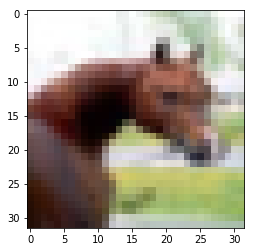

In [0]:
plt.imshow(X_test[random_image])

In [0]:
class_names[np.argmax(predictions[0])]

'deer'

## Etapa 8: Enviando a requisição POST para um modelo específico que está armazendo no servidor

In [0]:
specific_json_response = requests.post(url="http://localhost:8501/v1/models/cifar10/versions/1:predict", data = data, headers = headers)

In [0]:
specific_json_response

<Response [200]>